In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

C:\Users\thoma\AppData\Local\Temp\ipykernel_23608\852455855.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Analyse exploratoire des données**

In [2]:
train = pd.read_csv('train.csv')
train.info()
train.describe()
test = pd.read_csv('test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

La fonction describe() permet de voir les statistiques descriptives des données. Notre jeu de données comprend une liste de 1460 maisons. On remarque que pour notre variable cible SalePrice, la moyenne est de 180 921,2$ pour un minimum de 34 900$ et un maximum de 755 000$. La superficie du terrain LotArea varie considérablement, avec une moyenne d'environ 10 516 pieds carrés. Cela montre la diversité des propriétés en termes de taille de terrain. La qualité générale des matériaux et de la finition de la maison est évaluée sur une échelle de 1 à 10, avec une moyenne d'environ 6, ce qui suggère que la plupart des maisons sont de qualité au-dessus de la moyenne. YearBuilt et YearRemodAdd : Ces colonnes indiquent respectivement l'année de construction et l'année de la dernière rénovation des maisons. La moyenne de l'année de construction est de 1971, ce qui implique que le jeu de données inclut principalement des maisons construites dans la seconde moitié du 20ème siècle.

In [3]:
valeurs_manquantes = train.isnull().sum()
pourcentage_va = (train.isnull().sum() / len(train)) * 100

missing_df = pd.DataFrame({'Nombre de valeurs manquantes': valeurs_manquantes, 'Pourcentage': pourcentage_va})
missing_df = missing_df[missing_df['Nombre de valeurs manquantes'] > 0].sort_values(by='Pourcentage', ascending=False)

missing_df

,Nombre de valeurs manquantes,Pourcentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Face à la présence de nombreuses valeurs manquantes dans certaines colonnes, nous avons envisagé deux stratégies pour y remédier. La première stratégie consiste à éliminer les colonnes présentant un nombre élevé de valeurs manquantes. La seconde stratégie vise à remplacer les valeurs manquantes par la médiane pour les variables quantitatives et, pour les variables qualitatives, à les convertir en catégories, traitant ainsi les valeurs manquantes comme une catégorie distincte. Par exemple, pour une colonne comme PoolQC, l'absence de piscine constitue une information utile en soi. Nous avons opté pour la seconde stratégie afin de préserver un maximum d'informations.

In [4]:
quanti_cols = train.select_dtypes(include = ['int64', 'float64']).columns
quali_cols  = train.select_dtypes(include = ['object']).columns

imputer_quant = SimpleImputer(strategy = 'median')
train[quanti_cols] = imputer_quant.fit_transform(train[quanti_cols])

# On crée une nouvelle catégorie 'None' pour les valeurs manquantes des variables qualitatives
for col in quali_cols:
    train[col] = train[col].fillna('None')

# Contrôle de cohérence
train.isnull().sum().sum()

0

In [5]:
# Appliquer l'encodage one-hot aux variables catégorielles
train_encoded = pd.get_dummies(train, drop_first=True)

# Identifier les colonnes booléennes
bool_cols = train_encoded.select_dtypes(include='bool').columns

# Convertir les colonnes booléennes en 0 et 1
for col in bool_cols:
    train_encoded[col] = train_encoded[col].astype(int)

# Afficher les nouvelles dimensions du DataFrame après encodage
new_shape = train_encoded.shape

# Afficher un aperçu des nouvelles colonnes créées par l'encodage one-hot
train_encoded.head(), new_shape

(    Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
 0  1.0        60.0         65.0   8450.0          7.0          5.0     2003.0   
 1  2.0        20.0         80.0   9600.0          6.0          8.0     1976.0   
 2  3.0        60.0         68.0  11250.0          7.0          5.0     2001.0   
 3  4.0        70.0         60.0   9550.0          7.0          5.0     1915.0   
 4  5.0        60.0         84.0  14260.0          8.0          5.0     2000.0   
 
    YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
 0        2003.0       196.0       706.0  ...               0               0   
 1        1976.0         0.0       978.0  ...               0               0   
 2        2002.0       162.0       486.0  ...               0               0   
 3        1970.0         0.0       216.0  ...               0               0   
 4        2000.0       350.0       655.0  ...               0               0   
 
    SaleType_New  

In [6]:
# On applique la même transformation au jeu de test

# Séparation des variables quantitatives et qualitatives
quanti_cols_test = test.select_dtypes(include=['int64', 'float64']).columns
quali_cols_test = test.select_dtypes(include=['object']).columns

# Imputation des valeurs manquantes pour les variables quantitatives avec la médiane
imputer_quant_test = SimpleImputer(strategy='median')
test[quanti_cols_test] = imputer_quant_test.fit_transform(test[quanti_cols_test])

# Création d'une nouvelle catégorie 'None' pour les valeurs manquantes des variables qualitatives
for col in quali_cols_test:
    test[col] = test[col].fillna('None')

# Vérification de l'absence de valeurs manquantes
missing_values_after_imputation = test.isnull().sum().sum()

# Application de l'encodage one-hot aux variables catégorielles
test_encoded = pd.get_dummies(test, drop_first=True)

# Identification des colonnes booléennes
bool_cols_test = test_encoded.select_dtypes(include='bool').columns

# Conversion des colonnes booléennes en 0 et 1
for col in bool_cols_test:
    test_encoded[col] = test_encoded[col].astype(int)

# Nouvelles dimensions du DataFrame après encodage
new_shape_test = test_encoded.shape

missing_values_after_imputation, new_shape_test, test_encoded.head()

(0,
 (1459, 249),
        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
 0  1461.0        20.0         80.0  11622.0          5.0          6.0   
 1  1462.0        20.0         81.0  14267.0          6.0          6.0   
 2  1463.0        60.0         74.0  13830.0          5.0          5.0   
 3  1464.0        60.0         78.0   9978.0          6.0          6.0   
 4  1465.0       120.0         43.0   5005.0          8.0          5.0   
 
    YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
 0     1961.0        1961.0         0.0       468.0  ...               0   
 1     1958.0        1958.0       108.0       923.0  ...               0   
 2     1997.0        1998.0         0.0       791.0  ...               0   
 3     1998.0        1998.0        20.0       602.0  ...               0   
 4     1992.0        1992.0         0.0       263.0  ...               0   
 
    SaleType_New  SaleType_None  SaleType_Oth  SaleType_WD  \
 0             0

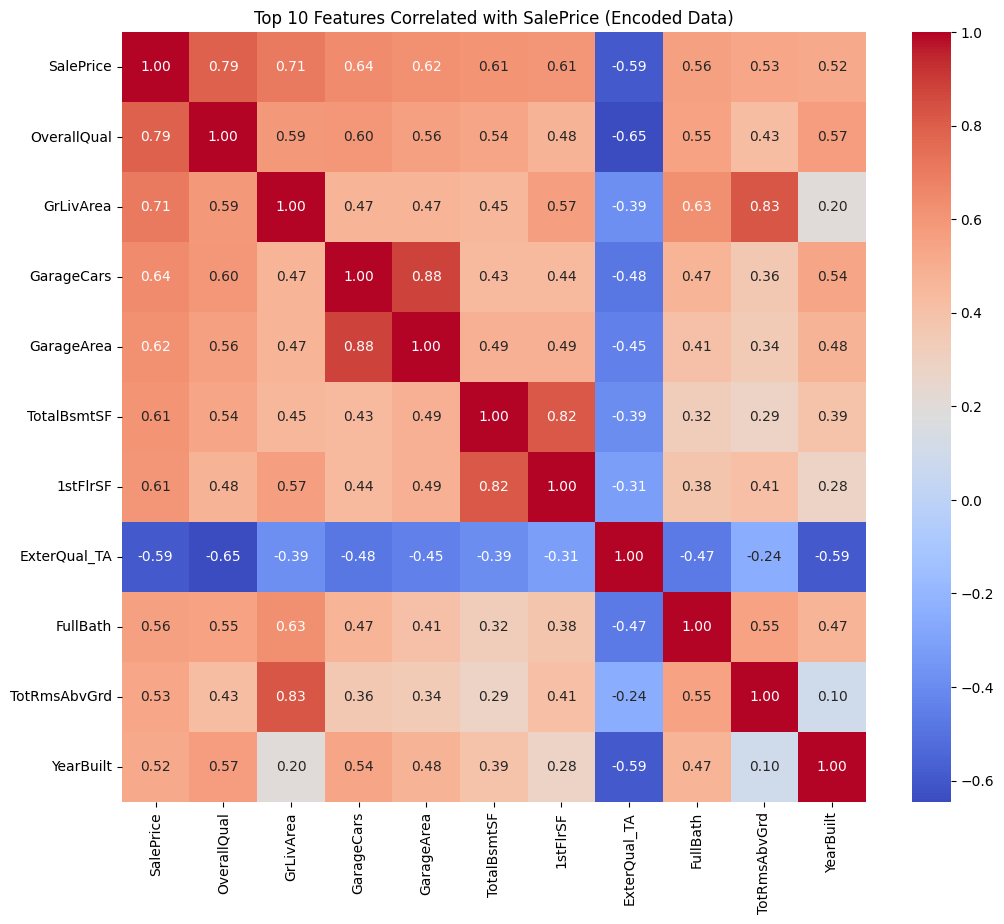

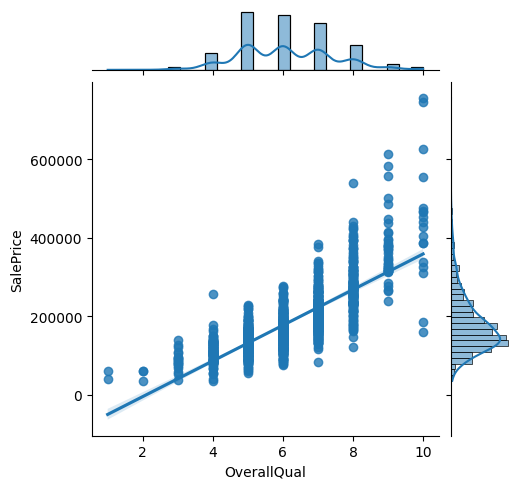

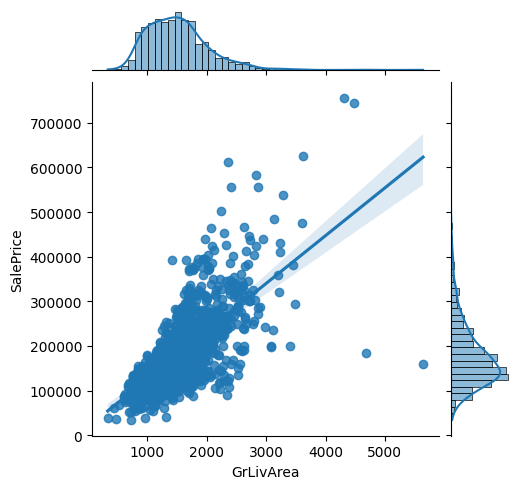

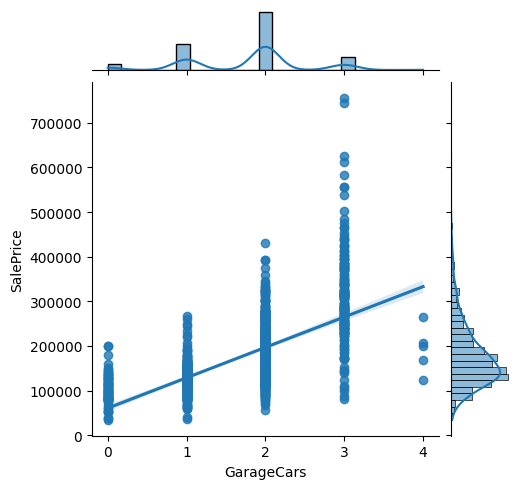

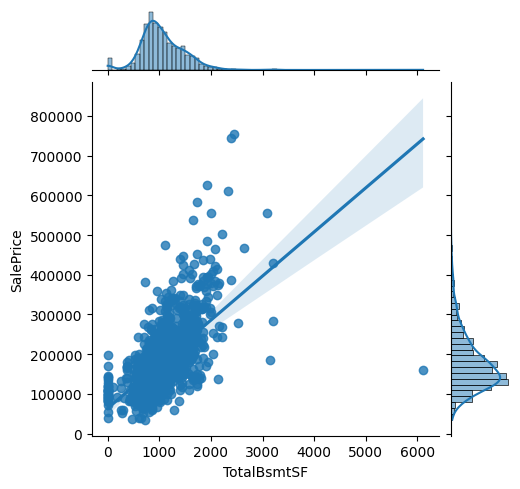

In [7]:
# Recalculer la matrice de corrélation sur le DataFrame encodé
correlation_matrix_encoded = train_encoded.corr()

# Sélectionner les 10 caractéristiques les plus corrélées avec SalePrice dans le DataFrame encodé
top_correlated_features_encoded = correlation_matrix_encoded['SalePrice'].sort_values(key=abs, ascending=False).head(11).index

# Calculer la matrice de corrélation pour ces caractéristiques encodées
top_corr_matrix_encoded = train_encoded[top_correlated_features_encoded].corr()

# Afficher la matrice de corrélation pour les caractéristiques encodées avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix_encoded, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 Features Correlated with SalePrice (Encoded Data)")
plt.show()

pairs_to_plot = [('OverallQual', 'SalePrice'), ('GrLivArea', 'SalePrice'), ('GarageCars', 'SalePrice'), ('TotalBsmtSF', 'SalePrice')]

# Générer à nouveau les nuages de points pour ces paires
for x, y in pairs_to_plot:
    sns.jointplot(x = x, y = y, data = train_encoded, kind = "reg", height = 5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

**Modélisation**

On va séparer notre jeu train en deux sous-ensembles : train_set et test_set. On va utiliser le train_set pour entraîner nos modèles et le test_set pour évaluer leur performance. On va utiliser la validation croisée pour évaluer la performance de nos modèles. On va comparer les performances de plusieurs modèles de régression : régression linéaire, régression Ridge, régression Lasso, régression ElasticNet, Random Forest, Gradient Boosting et XGBoost etc. On va sélectionner le modèle qui donne la meilleure performance sur le test_set. On essaiera ensuite sur test.csv pour envoyer les résultats sur kaggle.

**Séparation des données**

In [8]:
train_set, test_set = train_test_split(train_encoded, test_size=0.2)

**Modèle de regression simple**

On va récupérer les variables les plus importantes d'après le coefficient de corrélation. On fait ensuite une regression simple sur les 3 variables les plus corrélées avec SalePrice.

In [9]:
# Fonction pour calculer l'accuracy à ±5% de marge d'erreur
def calculate_accuracy_within_margin(y_true, y_pred, margin_percentage=5):
    margin_of_error = y_true * (margin_percentage / 100.0)
    is_within_margin = np.abs(y_true - y_pred) <= margin_of_error
    accuracy = np.mean(is_within_margin)
    return accuracy

# Calcul de la matrice de corrélation sur le jeu d'entraînement
correlation_matrix = train_set.corr()

# Trouver les 3 variables les plus corrélées avec SalePrice
top_correlated_variables = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:4]

# Préparation des résultats
results_ols = []

for variable in top_correlated_variables.index:
    # Préparation des données
    X_train = train_set[[variable]]
    y_train = train_set['SalePrice']
    X_test = test_set[[variable]]
    y_test = test_set['SalePrice']
    
    # Ajout d'une constante au modèle (intercept)
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    # Ajustement du modèle en utilisant OLS
    model_ols = sm.OLS(y_train, X_train_sm).fit()
    
    # Prédictions sur l'ensemble de test
    predictions_ols = model_ols.predict(X_test_sm)
    
    # Calcul du RMSE et du R² sur l'ensemble de test
    rmse_ols = np.sqrt(mean_squared_error(y_test, predictions_ols))
    r2_ols = r2_score(y_test, predictions_ols)
    
    # Calcul de l'accuracy à ±5% de marge d'erreur
    accuracy_within_5 = calculate_accuracy_within_margin(y_test, predictions_ols, 5)
    
    # Stockage des résultats
    results_ols.append({
        'Variable': variable,
        'Coefficient': model_ols.params[1],  # Coefficient de la variable
        'Intercept': model_ols.params[0],  # Intercept
        'RMSE': rmse_ols,
        'R²': r2_ols,
        'R² Adjusted': model_ols.rsquared_adj,
        'Accuracy (±5%)': accuracy_within_5
    })

# Conversion des résultats en DataFrame pour une meilleure lisibilité
results_ols_df = pd.DataFrame(results_ols)

results_ols_df

C:\Users\thoma\AppData\Local\Temp\ipykernel_23608\3726330199.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': model_ols.params[1],  # Coefficient de la variable
C:\Users\thoma\AppData\Local\Temp\ipykernel_23608\3726330199.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Intercept': model_ols.params[0],  # Intercept
C:\Users\thoma\AppData\Local\Temp\ipykernel_23608\3726330199.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

,Variable,Coefficient,Intercept,RMSE,R²,R² Adjusted,Accuracy (±5%)
0,OverallQual,44655.381725,-91309.472795,52073.199448,0.615244,0.628005,0.212329
1,GrLivArea,109.568391,15259.835214,61936.596359,0.455683,0.514634,0.208904
2,GarageCars,67011.793646,62218.768668,65492.317880,0.391392,0.414739,0.157534


Le R² est plutôt faible pour nos 3 variables, indiquant qu'une grande partie de la variance de SalePrice n'est pas expliquée par ces variables. De plus, on remarque que pour les 3 modèles, le taux de bonnes prédictions est très faible : 22% pour le meilleur modèle. On peut donc conclure que ces modèles ne sont pas satisfaisants.

**Modèle de régression multiple**

On va régresser SalePrice sur les 3 variables que nous avons testé pour la régression simple, ensuite nous allons régresser sur toutes les variables.

In [10]:
# Calculating a multiple regression using the top 3 correlated variables with SalePrice.

# Preparing the data for multiple regression
X_train_multiple = sm.add_constant(train_set[top_correlated_variables.index])  # Adding a constant for OLS
y_train_multiple = train_set['SalePrice']
X_test_multiple = sm.add_constant(test_set[top_correlated_variables.index])
y_test_multiple = test_set['SalePrice']

# Fitting the model using OLS for multiple regression
model_ols_multiple = sm.OLS(y_train_multiple, X_train_multiple).fit()

# Predictions on the test set
predictions_ols_multiple = model_ols_multiple.predict(X_test_multiple)

# Calculating RMSE and R² on the test set
rmse_ols_multiple = np.sqrt(mean_squared_error(y_test_multiple, predictions_ols_multiple))
r2_ols_multiple = r2_score(y_test_multiple, predictions_ols_multiple)

# Calculating accuracy within a 5% margin
accuracy_within_5_multiple = calculate_accuracy_within_margin(y_test_multiple, predictions_ols_multiple, 5)

# Storing results for multiple regression
results_ols_multiple = {
    'Variables': ', '.join(top_correlated_variables.index),
    'RMSE': rmse_ols_multiple,
    'R²': r2_ols_multiple,
    'R² Adjusted': model_ols_multiple.rsquared_adj,
    'Accuracy (±5%)': accuracy_within_5_multiple
}

# Convert the results to a DataFrame for better readability
results_ols_multiple_df = pd.DataFrame([results_ols_multiple])

results_ols_multiple_df


,Variables,RMSE,R²,R² Adjusted,Accuracy (±5%)
0,"OverallQual, GrLivArea, GarageCars",45082.43248,0.711616,0.74605,0.256849


On remarque qu'on obtiens désormais un R² de 0.93, ce qui est bien meilleur que pour la régression simple. Cela indique que la majorité de la variance de SalePrice est expliquée par les variables que nous avons utilisé. Cependant, de nombreuses varirables ont une p-value élevée, indiquant qu'elles ne sont pas significatives pour expliquer SalePrice. Nous allons donc essayer de régresser sur un sous-ensemble de ces variables.

In [11]:
# Preparing the data for multiple regression with all variables
X_train_all = sm.add_constant(train_set.drop(columns=['SalePrice']))  # Adding a constant for OLS
y_train_all = train_set['SalePrice']
X_test_all = sm.add_constant(test_set.drop(columns=['SalePrice']))
y_test_all = test_set['SalePrice']

# Fitting the model using OLS for multiple regression with all variables
model_ols_all = sm.OLS(y_train_all, X_train_all).fit()

# Predictions on the test set with all variables
predictions_ols_all = model_ols_all.predict(X_test_all)

# Calculating RMSE and R² on the test set with all variables
rmse_ols_all = np.sqrt(mean_squared_error(y_test_all, predictions_ols_all))
r2_ols_all = r2_score(y_test_all, predictions_ols_all)

# Calculating accuracy within a 5% margin with all variables
accuracy_within_5_all = calculate_accuracy_within_margin(y_test_all, predictions_ols_all, 5)

# Storing results for multiple regression with all variables
results_ols_all = {
    'RMSE': rmse_ols_all,
    'R²': r2_ols_all,
    'R² Adjusted': model_ols_all.rsquared_adj,
    'Accuracy (±5%)': accuracy_within_5_all
}

# Convert the results to a DataFrame for better readability
results_ols_all_df = pd.DataFrame([results_ols_all])

results_ols_all_df

,RMSE,R²,R² Adjusted,Accuracy (±5%)
0,39430.56053,0.779391,0.915433,0.386986


In [12]:
# Extraction des variables significatives (p.value < 0.05)
significant_variables = model_ols_all.pvalues[model_ols_all.pvalues < 0.05].index.tolist()

# Suppression de la constante ajoutée pour OLS, si présente
if 'const' in significant_variables:
    significant_variables.remove('const')

# Préparation des données pour la régression multiple avec uniquement les variables significatives
X_train_significant = sm.add_constant(train_set[significant_variables])  # Ajout d'une constante pour OLS
y_train_significant = train_set['SalePrice']
X_test_significant = sm.add_constant(test_set[significant_variables])
y_test_significant = test_set['SalePrice']

# Ajustement du modèle en utilisant OLS pour la régression multiple avec les variables significatives
model_ols_significant = sm.OLS(y_train_significant, X_train_significant).fit()

# Prédictions sur l'ensemble de test avec les variables significatives
predictions_ols_significant = model_ols_significant.predict(X_test_significant)

# Calcul du RMSE et du R² sur l'ensemble de test avec les variables significatives
rmse_ols_significant = np.sqrt(mean_squared_error(y_test_significant, predictions_ols_significant))
r2_ols_significant = r2_score(y_test_significant, predictions_ols_significant)

# Calcul de la précision à ±5% de marge d'erreur avec les variables significatives
accuracy_within_5_significant = calculate_accuracy_within_margin(y_test_significant, predictions_ols_significant, 5)

# Stockage des résultats pour la régression multiple avec les variables significatives
results_ols_significant = {
    'RMSE': rmse_ols_significant,
    'R²': r2_ols_significant,
    'R² Adjusted': model_ols_significant.rsquared_adj,
    'Accuracy (±5%)': accuracy_within_5_significant
}

# Conversion des résultats en DataFrame pour une meilleure lisibilité
results_ols_significant_df = pd.DataFrame([results_ols_significant])

results_ols_significant_df


,RMSE,R²,R² Adjusted,Accuracy (±5%)
0,48642.642028,0.664269,0.895596,0.390411


**Régression non paramétrique**

In [18]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardisation des données (important pour la régression LASSO)
scaler = StandardScaler()

# Préparation des données d'entraînement et de test, en excluant la constante ajoutée précédemment
X_train_scaled = scaler.fit_transform(train_set[significant_variables])
X_test_scaled = scaler.transform(test_set[significant_variables])

# Ajustement du modèle LASSO avec validation croisée pour choisir le meilleur alpha
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X_train_scaled, y_train_significant)

# Prédictions sur l'ensemble de test
predictions_lasso = lasso_cv.predict(X_test_scaled)

# Calcul du RMSE et du R² sur l'ensemble de test
rmse_lasso = np.sqrt(mean_squared_error(y_test_significant, predictions_lasso))
r2_lasso = r2_score(y_test_significant, predictions_lasso)

# Calcul de la précision à ±5% de marge d'erreur
accuracy_within_5_lasso = calculate_accuracy_within_margin(y_test_significant, predictions_lasso, 5)

# Stockage des résultats pour la régression LASSO
results_lasso = {
    'Alpha': lasso_cv.alpha_,
    'RMSE': rmse_lasso,
    'R²': r2_lasso,
    'Accuracy (±5%)': accuracy_within_5_lasso
}

# Conversion des résultats en DataFrame pour une meilleure lisibilité
results_lasso_df = pd.DataFrame([results_lasso])

results_lasso_df


,Alpha,RMSE,R²,Accuracy (±5%)
0,101.064139,48378.962182,0.667899,0.390411
